In [102]:
import numpy as np
import pandas as pd
import re
import gensim
from nltk.tokenize.treebank import TreebankWordTokenizer, TreebankWordDetokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [35]:
Train = pd.read_csv('SentimentAnalysis/train.csv')
Test = pd.read_csv('SentimentAnalysis/test.csv')

In [36]:
Train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [59]:
Train.sentiment.value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [37]:
Train.dropna(inplace=True)
Test.dropna(inplace=True)

In [52]:
X_train, y_train = (Train.text, Train.sentiment)
X_test, y_test = (Test.text, Test.sentiment)

In [46]:
def clean(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [47]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [48]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [49]:
X_train.values.tolist()

[' I`d have responded, if I were going',
 ' Sooo SAD I will miss you here in San Diego!!!',
 'my boss is bullying me...',
 ' what interview! leave me alone',
 ' Sons of ****, why couldn`t they put them on the releases we already bought',
 'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth',
 '2am feedings for the baby are fun when he is all smiles and coos',
 'Soooo high',
 ' Both of you',
 ' Journey!? Wow... u just became cooler.  hehe... (is that possible!?)',
 ' as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff',
 'I really really like the song Love Story by Taylor Swift',
 'My Sharpie is running DANGERously low on ink',
 'i want to go to music tonight but i lost my voice.',
 'test test from the LG enV2',
 'Uh oh, I am sunburned',
 ' S`ok, trying to plot alternatives as we speak *sigh*',
 'i`ve been sick for the past few days  and thus, my hair looks wierd.  if i didnt have a hat on i

In [53]:
temp = []
#Splitting pd.Series to list
data_to_list = X_train.values.tolist()
for i in range(len(data_to_list)):
    temp.append(clean(data_to_list[i]))
data_words = list(sent_to_words(temp))
X_train = []
for i in range(len(data_words)):
    X_train.append(detokenize(data_words[i]))

In [54]:
temp = []
#Splitting pd.Series to list
data_to_list = X_test.values.tolist()
for i in range(len(data_to_list)):
    temp.append(clean(data_to_list[i]))
data_words = list(sent_to_words(temp))
X_test = []
for i in range(len(data_words)):
    X_test.append(detokenize(data_words[i]))

In [60]:
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

In [61]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# X_train
sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=max_len)

# X_test
sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=max_len)

In [62]:
X_train

array([[   0,    0,    0, ...,   65,  139,   42],
       [   0,    0,    0, ...,    8, 1400, 2205],
       [   0,    0,    0, ..., 1301,    7,   13],
       ...,
       [   0,    0,    0, ...,  624,  837, 2731],
       [   0,    0,    0, ...,   23,  663,    4],
       [   0,    0,    0, ..., 2206,  218,  634]], dtype=int32)

In [91]:
model = Sequential()
model.add(layers.Embedding(max_words + 1, 50))
model.add(layers.Bidirectional(layers.LSTM(50,return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(50)))
model.add(layers.Dense(3,activation='softmax'))

In [92]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [93]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 50)          250050    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 100)         40400     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 303       
Total params: 351,153
Trainable params: 351,153
Non-trainable params: 0
_________________________________________________________________


In [94]:
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test))

Epoch 1/70
859/859 [==============================] - 129s 143ms/step - loss: 0.8947 - accuracy: 0.5635 - val_loss: 0.6731 - val_accuracy: 0.7199
Epoch 2/70
859/859 [==============================] - 129s 151ms/step - loss: 0.5973 - accuracy: 0.7613 - val_loss: 0.6495 - val_accuracy: 0.7340
Epoch 3/70
859/859 [==============================] - 122s 143ms/step - loss: 0.5072 - accuracy: 0.8025 - val_loss: 0.6522 - val_accuracy: 0.7284
Epoch 4/70
859/859 [==============================] - 121s 141ms/step - loss: 0.4536 - accuracy: 0.8279 - val_loss: 0.7074 - val_accuracy: 0.7295
Epoch 5/70
859/859 [==============================] - 113s 132ms/step - loss: 0.3997 - accuracy: 0.8514 - val_loss: 0.7631 - val_accuracy: 0.7213
Epoch 6/70
859/859 [==============================] - 115s 134ms/step - loss: 0.3510 - accuracy: 0.8704 - val_loss: 0.8457 - val_accuracy: 0.7105
Epoch 7/70
859/859 [==============================] - 125s 145ms/step - loss: 0.2971 - accuracy: 0.8934 - val_loss: 0.9106 -

KeyboardInterrupt: 

In [95]:
preds = model.predict(X_test)

In [97]:
classes = preds.argmax(axis=1)

<AxesSubplot:>

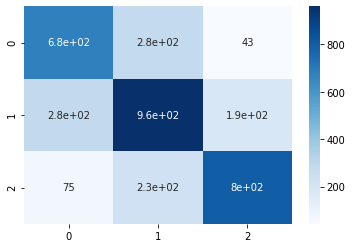

In [101]:
sns.heatmap(confusion_matrix(y_test, classes), annot=True, cmap='Blues')

In [104]:
print(classification_report(y_test, classes))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67      1001
           1       0.65      0.67      0.66      1430
           2       0.77      0.72      0.75      1103

    accuracy                           0.69      3534
   macro avg       0.69      0.69      0.69      3534
weighted avg       0.69      0.69      0.69      3534



In [115]:
model = Sequential()
model.add(layers.Embedding(max_words + 1, 50))
model.add(layers.Conv1D(30, 6, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(30, 6, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
859/859 [==============================] - 11s 12ms/step - loss: 1.0441 - acc: 0.4471 - val_loss: 0.7528 - val_acc: 0.6927
Epoch 2/10
859/859 [==============================] - 11s 13ms/step - loss: 0.7594 - acc: 0.6852 - val_loss: 0.6804 - val_acc: 0.7184
Epoch 3/10
859/859 [==============================] - 10s 12ms/step - loss: 0.6811 - acc: 0.7252 - val_loss: 0.6687 - val_acc: 0.7315
Epoch 4/10
859/859 [==============================] - 10s 12ms/step - loss: 0.6122 - acc: 0.7619 - val_loss: 0.6904 - val_acc: 0.7221
Epoch 5/10
443/859 [==============>...............] - ETA: 4s - loss: 0.5635 - acc: 0.7837

KeyboardInterrupt: 

In [116]:
preds = model.predict(X_test)

In [117]:
classes = preds.argmax(axis=1)

<AxesSubplot:>

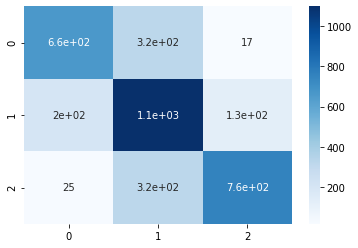

In [119]:
sns.heatmap(confusion_matrix(y_test, classes), annot=True, cmap='Blues')

In [120]:
print(classification_report(y_test, classes))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70      1001
           1       0.63      0.77      0.69      1430
           2       0.84      0.69      0.75      1103

    accuracy                           0.71      3534
   macro avg       0.74      0.71      0.72      3534
weighted avg       0.73      0.71      0.71      3534



In [122]:
sentiment = ['Neutral','Negative','Positive']
sequence = tokenizer.texts_to_sequences(['deep learning is awesome'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'